In [153]:
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Mecab
import re

import matplotlib
import matplotlib.font_manager as fm
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # matplotlib 한글 맑은 고딕 폰트 설정
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
import matplotlib.pyplot as plt

okt = Okt()
mecab = Mecab()

In [154]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import requests
from bs4 import BeautifulSoup
import json
import time

In [144]:
review_list = []
pages = 100
for page in range(pages):
    url = 'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=auto1&templateId=&pool=cbox&_callback=jQuery1707609017391243922_1608381365685&lang=ko&country=&objectId=137863&categoryId=&pageSize=10&indexSize=10&groupId=&listType=OBJECT&pageType=default&page={}&refresh=false&sort=NEW&_=1608382297292'.format(page)
    params = {'ticket': 'auto1',
    # templateId: 
    'pool': 'cbox',
    '_callback': 'jQuery1707609017391243922_1608381365682',
    'lang': 'ko',
    # country: 
    'objectId': '137863',
    # 'categoryId': 
    'pageSize': 10,
    'indexSize': 10,
    # 'groupId': 
    'listType': 'OBJECT',
    'pageType': 'default',
    'page': page,
    'refresh': 'false',
    'sort': 'NEW',
    '_': 1608381559312}
    headers = {'referer': 'https://auto.naver.com/car/talk.nhn?yearsId=137863',
              'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'}
    time.sleep(5)
    resp = requests.get(url, data= params, headers = headers)
    soup = BeautifulSoup(resp.content, 'lxml')

    data = resp.text[resp.text.index('(') + 1 : resp.text.rindex(')')]
    temp_parser = json.loads(data)

    review_per_page = 10
    for i in range(review_per_page):
        contents = temp_parser['result']['commentList'][i]['contents']
        review_list.append(contents)

IndexError: list index out of range

In [149]:
from konlpy.tag import Mecab

mecab = Mecab()

In [167]:
review_list = set(review_list)

In [163]:
review_token = []
for review in review_list:
    review = re.sub('([a-zA-Z])','',review)
    review = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',review)
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)
    temp_token = []
    for word, pos in mecab.pos(review):
        if pos in ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN', 'MAG']:
            temp_token.append(word)
    review_token.append((' ').join(temp_token))

In [168]:
flaw_list = []
for review in review_list:
    if '결함' in review:
        flaw_list.append(review)

In [169]:
flaw_list

['오너나, 예비오너, 잠재고객들이 가입한 G80네이버카페도 결함때문에 다들 난리시던데...\n대기하는 사람은 뽑기잘되게 해달라며...수많은 차를 타봤지만, 그런 카페분위기는 처음...다들 기다리면서 어느정도는 뽑기 잘되게 해달라는 분위기는 이해하는데...그냥 전체적인분위기가 ㅋㅋㅋㅋ\n이차의 수준을 말해주는거 같음...\n특히 2.5T는...3.5T보다 더 결함이 많아서, 실 오너들조차 불안해 하며 타는 ㅋ\n그나마 법인들이 대안이 없어 사는 차이기도 하니, 판매율은 높겠지만...물론 국내한정...ㅋㅋ',
 '결함있음이차?',
 '유튜브 보면서 대충 조립하는 차를 타고싶니? 그러니까 맨날 결함 나오지..진짜 제네시스 아니고 쟤네실수다..귀족노조들 급여올려주고싶으면 그냥 타~',
 '출고되고 3일째 타고있는데 결함없고 아주 좋음 옵션을 빵빵하게 넣었더니 주위에서도 다들 차 좋다고 그럼 특히 실내 시그니처2 하바나 브라운으로 했드만 내부가 거의다 가죽이여서 진짜 고급짐  오히려 지금 상황에선 신차라서 그런지 독3보다 더 눈에 띄는 장점이있고 머 좀 지나면 국민차 되겠지만 ㅋㅋ 머 비공개들 많이 누르겠지만 솔직하게 오너입장으로 얘기했음 30대중반인데 솔직히 40대 초반정도가 딱 어울릴듯함 디자인이 젊은 스타일로 나왔다해도 아직 내가 타기엔 좀 올드해보이는건 어쩔수없음 그래도 나름 만족합니다 7년정도 타고 풀체인지 타이밍에 벤츠로 한번 갈아타볼 예정',
 '처음에는 차 잘나온거 같다는 반응들 많이봤는데 아니나다를까 결함 투성이 얘기가 많이 나오네요. 하긴 얘네들 초기 신차 출시 이후 조용히 별 탈 없었던 적은 지금껏 한 번도 없었으니... 현기차 많이 타왔지만 새로 막 출시해서 이것저것 적용하는 신차보단 어느정도 끝물모델까지 가야 완성도가 높아지는듯 싶습니다. 뽑기 잘못하면 바로 베타테스터행이죠.',
 '원래 ㅋㅋㅋㅋㅋㅋ차량출시하고 소비자들이 결함 뭐다뭐다 말 나올 때까지 기다리다가 사람들 말 듣고 개선하는 거 아님??ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


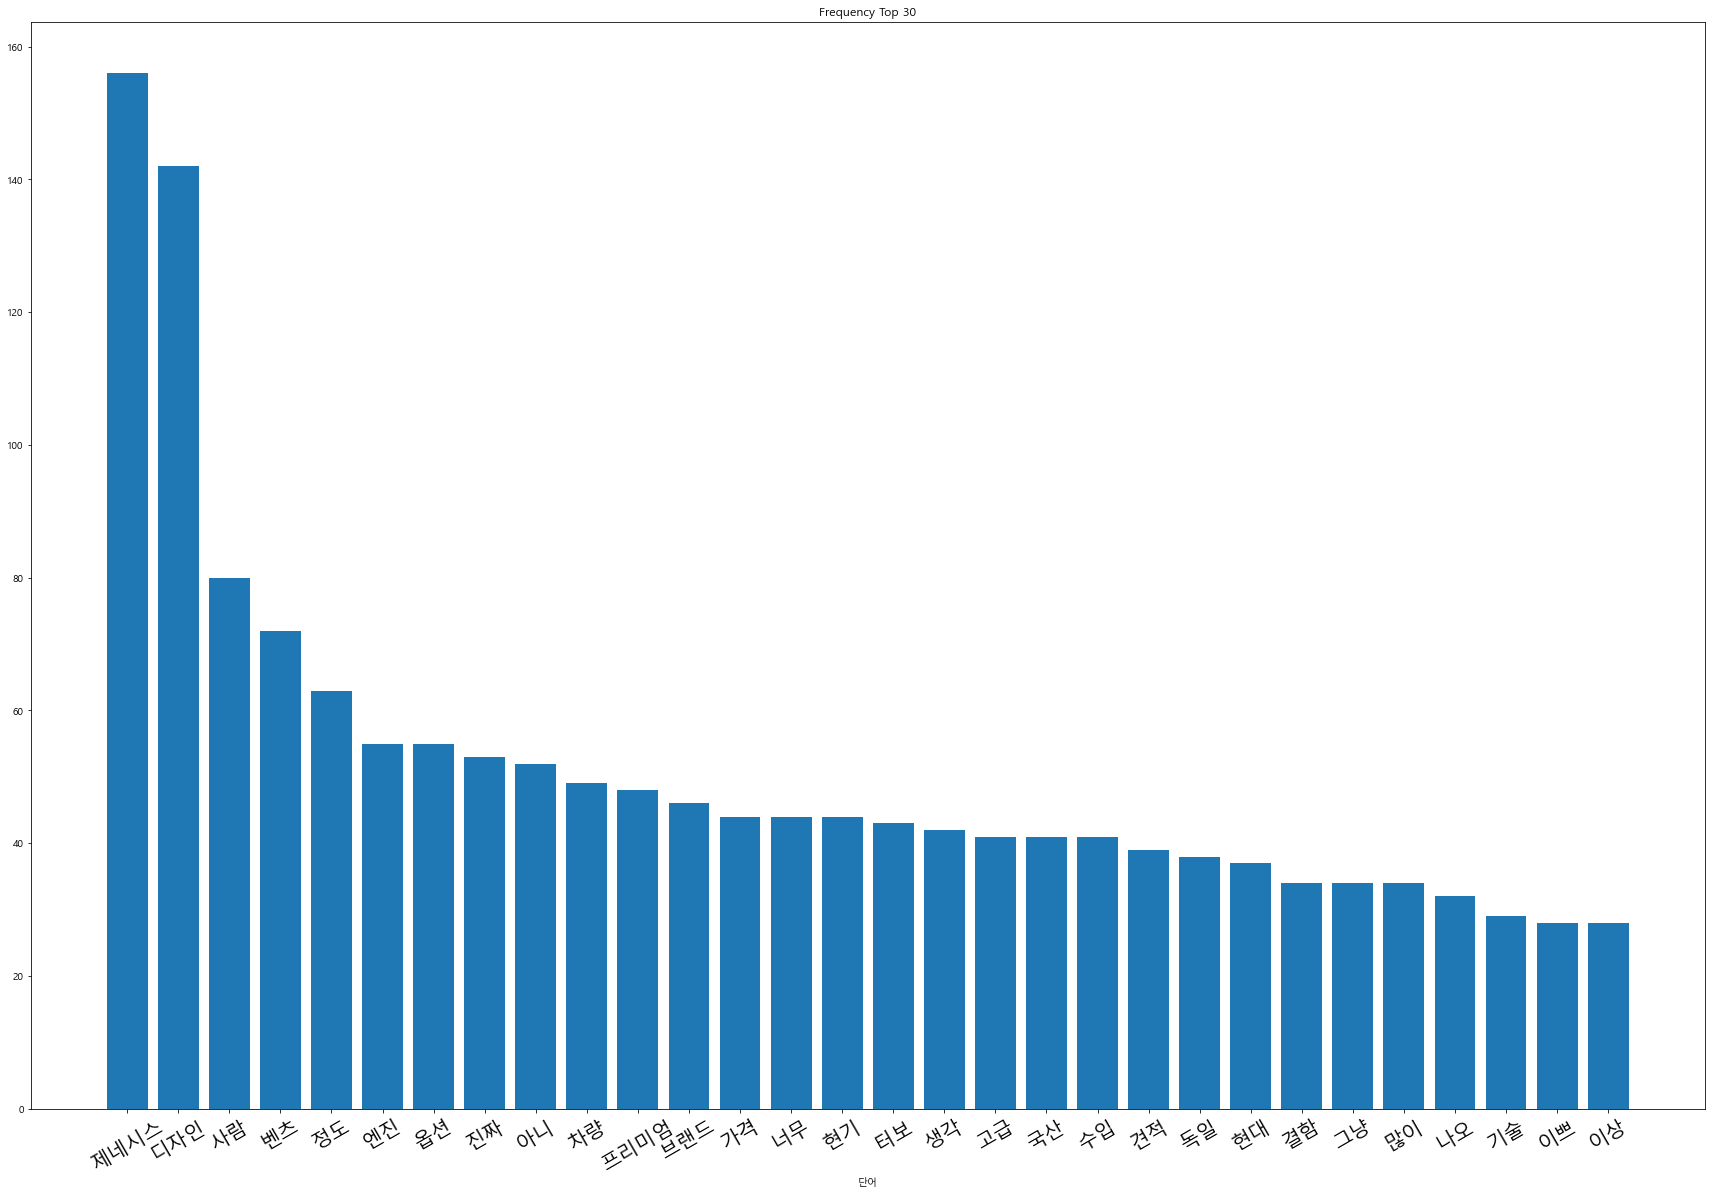

In [164]:
tf_vect = CountVectorizer(max_df = 0.85, max_features=10000, ngram_range=(1,3))
dtm = tf_vect.fit_transform(review_token)

vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()
words = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

max = 30
plt.figure(figsize=(30,20))
plt.bar(range(max), [i[1] for i in words[:max]])
plt.title('Frequency Top 30')
plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max))
ax.set_xticklabels([i[0] for i in words[:max]], rotation=30, size=20)
plt.show()